<a href="https://colab.research.google.com/github/shunitavni/Speech-Emotion-Recognition/blob/master/VGG_4_CLASSES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#%% Imports
import numpy as np;
import torch;
import torch.nn as nn
import torch.nn.functional as F


# Model Configuration

class Net(nn.Module):
    def __init__(self,device):
        self.device = device;
        # super Constructor
        super(Net, self).__init__()
        # Input size is (dim = 1, h = 161, w = 101)
        # Conv layer output is [(Width - Kernel +2*Padding) / (Stride) ] + 1

        conv1 = [nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size=3,stride = 1,padding = 1),
                 nn.BatchNorm2d(64),
                 nn.ReLU(inplace=True),
                 nn.MaxPool2d(kernel_size=2,stride=2)];

        self.conv1 = nn.Sequential(*conv1)

        conv2 = [nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3,stride = 1,padding = 1),
                 nn.BatchNorm2d(128),
                 nn.ReLU(inplace=True),
                 nn.MaxPool2d(kernel_size=2,stride=2)];

        self.conv2 = nn.Sequential(*conv2)

        conv3 = [nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size=3,stride = 1,padding = 1),
                 nn.BatchNorm2d(256),
                 nn.ReLU(inplace=True)];

        self.conv3 = nn.Sequential(*conv3)

        conv4 = [nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size=3,stride = 1,padding = 1),
                 nn.BatchNorm2d(256),
                 nn.ReLU(inplace=True)];

        self.conv4 = nn.Sequential(*conv4)

        conv5 = [nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size=3,stride = 1,padding = 1),
                 nn.BatchNorm2d(256),
                 nn.ReLU(inplace=True),
                 nn.MaxPool2d(kernel_size=2,stride=2)];

        self.conv5 = nn.Sequential(*conv5)

        conv6 = [nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size=3,stride = 1,padding = 1),
                 nn.BatchNorm2d(512),
                 nn.ReLU(inplace=True)];

        self.conv6 = nn.Sequential(*conv6)

        conv7 = [nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size=3,stride = 1,padding = 1),
                 nn.BatchNorm2d(512),
                 nn.ReLU(inplace=True),
                 nn.MaxPool2d(kernel_size=2,stride=2)];

        self.conv7 = nn.Sequential(*conv7)

        conv8 = [nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size=3,stride = 1,padding = 1),
                 nn.BatchNorm2d(512),
                 nn.ReLU(inplace=True)];

        self.conv8 = nn.Sequential(*conv8)

        conv9 = [nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size=3,stride = 1,padding = 1),
                 nn.BatchNorm2d(512),
                 nn.ReLU(inplace=True),
                 nn.MaxPool2d(kernel_size=2,stride=2)];

        self.conv9 = nn.Sequential(*conv9)


        conv10 = [nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size=3,stride = 1,padding = 1),
                 nn.BatchNorm2d(512),
                 nn.ReLU(inplace=True),
                 nn.Dropout2d(),
                  nn.AvgPool2d(kernel_size=1,stride=1)];

        self.conv10 = nn.Sequential(*conv10)


        fc = [nn.Linear(7680,512),
              nn.ReLU(inplace=True),
              nn.Linear(512,4),
              nn.LogSoftmax()
              ];

        self.fc = nn.Sequential(*fc);


    def setCriterion(self,criterion):
        self.criterion = criterion;

    def setOptimizer(self,optimizer):
        self.optimizer = optimizer;


    def forward(self, x):
        x = self.conv1(x);
        x = self.conv2(x);
        x = self.conv3(x);
        x = self.conv4(x);
        x = self.conv5(x);
        x = self.conv6(x);
        x = self.conv7(x);
        x = self.conv8(x);
        x = self.conv9(x);
        x = self.conv10(x);
        x = x.view(x.size(0),-1)
        return self.fc(x);

    def fit(self,loader,epochs):
        for epoch in range(epochs):
            for batch_idx, (data, labels) in enumerate(loader):
                # Zero the gradients
                self.optimizer.zero_grad()

                # Forward propogation
                inputs, targets = data.to(self.device),labels.to(self.device)

                # Calculate network's output
                output = self.forward(inputs)

                # Calculate the loss
                loss = self.criterion(output, targets.long())

                # Calculate the derivatives
                loss.backward()

                # Update the weights
                self.optimizer.step()

                # Print the batch loss
                if (batch_idx % 20 == 0):
                  print(f"Epoch: {epoch} Batch: {batch_idx} Loss: {loss.item()}")

        print("Training completed")

    def predict(self,data):
        predictions = [];
        with torch.no_grad():
            for d in data:
                d = d.to(self.device);
                val = self.forward(d);
                unused,val = val.max(1)
                predictions.append(val.item());
        return np.array(predictions);


    def calculateLoss(self,Loader):
        Loss = [];
        with torch.no_grad():
            for index, data in enumerate(Loader):
                # Get the images and the labels
                images, labels = data[0].to(self.device),data[1].to(self.device);

                # Forward propogation
                outputs = self.forward(images);

                # Calculate the loss
                loss = self.criterion(outputs, labels);

                # Add the batch loss to the list
                Loss.append(loss.item());

        # Return the average batch loss
        return np.mean(Loss);

    def calculateAccuracy(self,Loader):
        correct = 0
        total = 0
        with torch.no_grad():
            for data in Loader:
                images, labels = data[0].to(self.device),data[1].to(self.device)
                outputs = self.forward(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        acc = (100 * correct / total);
        print('Accuracy of the network %d %%' %acc)
        return acc;

    def fitWithMetrics(self,trainLoader,testLoader,epochs):
        trainLoss = [];
        trainAccuracy = [];
        testLoss = [];
        testAccuracy = [];

        for epoch in range(epochs):
            for batch_idx, (data, labels) in enumerate(trainLoader):
                self.optimizer.zero_grad()
                output = self.forward(data.to(self.device))
                loss = self.criterion(output, labels)
                loss.backward()
                self.optimizer.step()
                print(f"Epoch: {epoch} Batch: {batch_idx} Loss: {loss.item()}")

            # Calculate loss on train
            trainLoss.append(self.calculateLoss(trainLoader));

            # Calculate Accuracy on train
            trainAccuracy.append(self.calculateAccuracy(trainLoader));

            # Calculate loss on test
            testLoss.append(self.calculateLoss(testLoader));

            # Calculate Accuracy on test
            testAccuracy.append(self.calculateAccuracy(testLoader));



            print(f"Epoch: {epoch} train loss: {trainLoss} validation loss: {testLoss}")
        print("Training completed")
        return trainLoss,trainAccuracy,testLoss,testAccuracy;


In [ ]:
pip install conda

     |████████████████████████████████| 307kB 3.5MB/s 
     |████████████████████████████████| 71kB 6.2MB/s 
     |████████████████████████████████| 112kB 10.7MB/s 
     |████████████████████████████████| 552kB 11.1MB/s 
  Created wheel for conda: filename=conda-4.3.16-cp36-none-any.whl size=336938 sha256=0655fa8dcd9c11a273457881283b8ad9c6501537251a6cc749d0235de78579b5
  Stored in directory: /root/.cache/pip/wheels/a3/50/79/302742d53e2231ec545cb3791abfdd24de234021ed8e0588a0
  Created wheel for pycosat: filename=pycosat-0.6.3-cp36-cp36m-linux_x86_64.whl size=142847 sha256=ec4b55165b248cda3318aab4c50c5fd0e96633605889d19b8f4a1fe6964a6ec1
  Stored in directory: /root/.cache/pip/wheels/c4/67/ff/5570304e45814eccef48a3c69c3af25d0456ed3a34eddbbe38
Successfully built conda pycosat


In [ ]:
pip install pysoundfile

In [ ]:
import os
import os.path

import soundfile as sf
import librosa
import numpy as np
import torch
import torch.utils.data as data

AUDIO_EXTENSIONS = [
    '.wav', '.WAV',
]


def is_audio_file(filename):
    return any(filename.endswith(extension) for extension in AUDIO_EXTENSIONS)


def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx


def make_dataset(dir, class_to_idx):
    spects = []
    dir = os.path.expanduser(dir)
    for target in sorted(os.listdir(dir)):
        d = os.path.join(dir, target)
        if not os.path.isdir(d):
            continue

        for root, _, fnames in sorted(os.walk(d)):
            for fname in sorted(fnames):
                if is_audio_file(fname):
                    path = os.path.join(root, fname)
                    item = (path, class_to_idx[target])
                    spects.append(item)
    return spects


def spect_loader(path, window_size, window_stride, window, normalize, max_len=101):
    y, sr = sf.read(path)
    # n_fft = 4096
    n_fft = int(sr * window_size)
    win_length = n_fft
    hop_length = int(sr * window_stride)

    # STFT
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length,
                     win_length=win_length, window=window)
    spect, phase = librosa.magphase(D)

    # S = log(S+1)
    spect = np.log1p(spect)

    # make all spects with the same dims
    # TODO: change that in the future
    if spect.shape[1] < max_len:
        pad = np.zeros((spect.shape[0], max_len - spect.shape[1]))
        spect = np.hstack((spect, pad))
    elif spect.shape[1] > max_len:
        spect = spect[:, :max_len]
    spect = np.resize(spect, (1, spect.shape[0], spect.shape[1]))
    spect = torch.FloatTensor(spect)

    # z-score normalization
    if normalize:
        mean = spect.mean()
        std = spect.std()
        if std != 0:
            spect.add_(-mean)
            spect.div_(std)

    return spect


class GCommandLoader(data.Dataset):
    """A google command data set loader where the wavs are arranged in this way: ::
        root/one/xxx.wav
        root/one/xxy.wav
        root/one/xxz.wav
        root/head/123.wav
        root/head/nsdf3.wav
        root/head/asd932_.wav
    Args:
        root (string): Root directory path.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        window_size: window size for the stft, default value is .02
        window_stride: window stride for the stft, default value is .01
        window_type: typye of window to extract the stft, default value is 'hamming'
        normalize: boolean, whether or not to normalize the spect to have zero mean and one std
        max_len: the maximum length of frames to use
     Attributes:
        classes (list): List of the class names.
        class_to_idx (dict): Dict with items (class_name, class_index).
        spects (list): List of (spects path, class_index) tuples
        STFT parameter: window_size, window_stride, window_type, normalize
    """

    def __init__(self, root, transform=None, target_transform=None, window_size=.02,
                 window_stride=.01, window_type='hamming', normalize=True, max_len=101):
        classes, class_to_idx = find_classes(root)
        spects = make_dataset(root, class_to_idx)
        if len(spects) == 0:
            raise (RuntimeError("Found 0 sound files in subfolders of: " + root + "Supported audio file extensions are: " + ",".join(AUDIO_EXTENSIONS)))

        self.root = root
        self.spects = spects
        self.classes = classes
        self.class_to_idx = class_to_idx
        self.transform = transform
        self.target_transform = target_transform
        self.loader = spect_loader
        self.window_size = window_size
        self.window_stride = window_stride
        self.window_type = window_type
        self.normalize = normalize
        self.max_len = max_len

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (spect, target) where target is class_index of the target class.
        """
        path, target = self.spects[index]
        spect = self.loader(path, self.window_size, self.window_stride, self.window_type, self.normalize, self.max_len)
        if self.transform is not None:
            spect = self.transform(spect)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return spect, target

    def __len__(self):
        return len(self.spects)


In [ ]:
import librosa    #Python Library for analysing audio
import soundfile
import os, glob, pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F;
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import os.path
import pdb

In [ ]:
# --------------------------------------------------------------------------------------------- #
                                        # Data Section
                        # Prepare all the data for training and prediction
# --------------------------------------------------------------------------------------------- #
AUDIO_EXTENSIONS = [
    '.wav', '.WAV',
]

def is_audio_file(filename):
    return any(filename.endswith(extension) for extension in AUDIO_EXTENSIONS)

def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

def make_dataset(dir, class_to_idx):
    spects = []
    dir = os.path.expanduser(dir)
    for target in sorted(os.listdir(dir)):
        d = os.path.join(dir, target)
        if not os.path.isdir(d):
            continue

        for root, _, fnames in sorted(os.walk(d)):
            for fname in sorted(fnames):
                if is_audio_file(fname):
                    path = os.path.join(root, fname)
                    item = (path, class_to_idx[target])
                    spects.append(item)
    return spects

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Get the directories which represent the classes
dirPath = "/content/drive/My Drive/Data4"

classes,class_to_idx = find_classes(dirPath)
spects = make_dataset(dirPath,class_to_idx);

In [ ]:
print("Loading the data..")
# Use the sound itself
X = [];
y = [];

i = 0;
myLen = len(spects);
for spect in spects:
    file, samplerate = librosa.load(spect[0], sr=4000)
    X.append(file);
    y.append(spect[1]);
    i = i + 1;
    if(i % 500 == 0):
        print(f"Loading in process: {i/myLen}")

# for i in range(10):
#     file, samplerate = librosa.load(spects[i][0], sr=4000)
#     X.append(file);
#     y.append(spects[i][1]);

print("Finished loading!")

Loading the data..
Loading in process: 0.0669882100750268
Loading in process: 0.1339764201500536
Loading in process: 0.20096463022508038
Loading in process: 0.2679528403001072
Loading in process: 0.334941050375134
Loading in process: 0.40192926045016075
Loading in process: 0.46891747052518756
Loading in process: 0.5359056806002144
Loading in process: 0.6028938906752411
Loading in process: 0.669882100750268
Loading in process: 0.7368703108252947
Loading in process: 0.8038585209003215
Loading in process: 0.8708467309753484
Loading in process: 0.9378349410503751
Finished loading!


In [ ]:
X_new = []

max_len = 16261;
for i in range(len(X)):
    x_len = len(X[i]);
    if(x_len <= max_len):
        X_new.append(np.concatenate((X[i],np.zeros(16261 - len(X[i])))).reshape(1,161,101))
    else:
        X_new.append( X[i][0:max_len].reshape(1,161,101) );

In [ ]:
# Shuffle
from sklearn.utils import shuffle
X_new,y = shuffle(X_new,y);

In [ ]:
# Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_new, y, test_size=0.33, random_state=42)

In [ ]:
X_train = torch.FloatTensor(np.array(X_train));
y_train = torch.from_numpy(np.array(y_train));
X_test = torch.FloatTensor(np.array(X_test));

dataset = torch.utils.data.TensorDataset(X_train,y_train)

train_loader = torch.utils.data.DataLoader(
        dataset, batch_size=5, shuffle=True,
        num_workers=0, pin_memory=True, sampler=None)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#%%
# Initialize the network
clf = Net(device)


#%%
# Print the network
print(clf)

Using device: cuda
Net(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0

In [ ]:
# Set the loss criterion
criterion = F.nll_loss;
clf.setCriterion(criterion);

# Set the optimizer
optimizer = optim.Adam(params=clf.parameters(), lr=0.0001);
clf.setOptimizer(optimizer);

# Set the network to training mode
clf.train();

# Set the network to CUDA
clf.to(device);

# Train the network
clf.fit(train_loader,80);


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 0 Batch: 0 Loss: 0.04143838956952095
Epoch: 0 Batch: 20 Loss: 0.0022295950911939144
Epoch: 0 Batch: 40 Loss: 0.010278129950165749
Epoch: 0 Batch: 60 Loss: 0.8752123117446899
Epoch: 0 Batch: 80 Loss: 0.15833711624145508
Epoch: 0 Batch: 100 Loss: 0.09964542090892792
Epoch: 0 Batch: 120 Loss: 0.6296706199645996
Epoch: 0 Batch: 140 Loss: 0.0006031036609783769
Epoch: 0 Batch: 160 Loss: 0.2985903322696686
Epoch: 0 Batch: 180 Loss: 0.013796234503388405
Epoch: 0 Batch: 200 Loss: 0.1819661557674408
Epoch: 0 Batch: 220 Loss: 0.3442099690437317
Epoch: 0 Batch: 240 Loss: 0.0659143477678299
Epoch: 0 Batch: 260 Loss: 0.002065372420474887
Epoch: 0 Batch: 280 Loss: 0.02356576919555664
Epoch: 0 Batch: 300 Loss: 0.21269121766090393
Epoch: 0 Batch: 320 Loss: 0.026526832953095436
Epoch: 0 Batch: 340 Loss: 0.04737968370318413
Epoch: 0 Batch: 360 Loss: 0.013088035397231579
Epoch: 0 Batch: 380 Loss: 0.0686769038438797
Epoch: 0 Batch: 400 Loss: 0.040851593017578125
Epoch: 0 Batch: 420 Loss: 0.358277708

In [ ]:
print("Predicting..")
test = [];
for i in range(len(X_test)):
    test.append(X_test[i].reshape(1,1,161,101));
y_pred=clf.predict(test)

print(np.unique(y_pred,return_counts=True))

from sklearn.metrics import classification_report

classes = ('ANG', 'HAP',
            'NEU', 'SAD')

target_names = classes
print(classification_report(y_test, y_pred, target_names=target_names))

Predicting..


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


(array([0, 1, 2, 3]), array([607, 709, 611, 537]))
              precision    recall  f1-score   support

         ANG       0.71      0.73      0.72       596
         HAP       0.57      0.64      0.60       628
         NEU       0.63      0.66      0.64       589
         SAD       0.77      0.64      0.70       651

    accuracy                           0.66      2464
   macro avg       0.67      0.67      0.67      2464
weighted avg       0.67      0.66      0.67      2464



In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true = y_test, y_pred = y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 66.44%


Accuracy Score : 0.6643668831168831
Report : 
              precision    recall  f1-score   support

           0       0.71      0.73      0.72       596
           1       0.57      0.64      0.60       628
           2       0.63      0.66      0.64       589
           3       0.77      0.64      0.70       651

    accuracy                           0.66      2464
   macro avg       0.67      0.67      0.67      2464
weighted avg       0.67      0.66      0.67      2464

Confusion Matrix :
[[433 123  21  19]
 [118 402  74  34]
 [ 34 101 386  68]
 [ 22  83 130 416]]


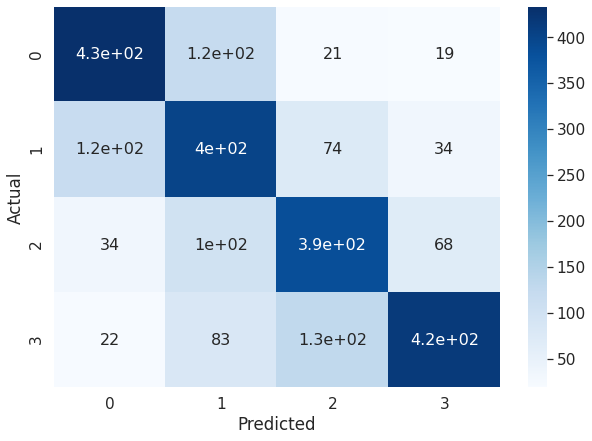

In [ ]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
  
results = confusion_matrix(y_test, torch.FloatTensor(y_pred)) 
df_cm = pd.DataFrame(results, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})




print ('Accuracy Score :',accuracy_score(y_test, y_pred)) 

print ('Report : ')

print (classification_report(y_test, y_pred)) 

print('Confusion Matrix :'  )  

print(results) 

In [ ]:
from torchsummary import summary
summary(clf, (1, 161, 101))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 161, 101]             640
       BatchNorm2d-2         [-1, 64, 161, 101]             128
              ReLU-3         [-1, 64, 161, 101]               0
         MaxPool2d-4           [-1, 64, 80, 50]               0
            Conv2d-5          [-1, 128, 80, 50]          73,856
       BatchNorm2d-6          [-1, 128, 80, 50]             256
              ReLU-7          [-1, 128, 80, 50]               0
         MaxPool2d-8          [-1, 128, 40, 25]               0
            Conv2d-9          [-1, 256, 40, 25]         295,168
      BatchNorm2d-10          [-1, 256, 40, 25]             512
             ReLU-11          [-1, 256, 40, 25]               0
           Conv2d-12          [-1, 256, 40, 25]         590,080
      BatchNorm2d-13          [-1, 256, 40, 25]             512
             ReLU-14          [-1, 256,

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
